# North Atlantic O2
    - This script shows a workflow of estimating O2 anomalies usign ESM output and a few ML regressors
    - O2 is estimated as a function of T, S, Stratification, long, lat, time
    - time is measured in the units of month since 1965-01
    - Estimation methods include Multiple Linear Regression, Support Vector Machine, and Neural Network
    - 85-15 divide between training and test data
    - K-fold cross validation for hyperparameter tuning for SVM, shallow and deep NN
    - Warning: this calculation takes a while!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw

### First prepare O2, T, S, stratification data

In [2]:
# access model output
model = 'GFDL-ESM4'
dir = '/glade/work/ito/dataset/model/'+model+'/'
dira= '/glade/work/acervania/dataset/model/'+model+'/'
ds0=xr.open_dataset(dir+'o2_'+model+'_196501-201412_subsampled.nc')
ds1=xr.open_dataset(dir+'so_'+model+'_196501-201412_subsampled.nc')
ds2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412_subsampled.nc')
ds3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412_subsampled.nc')

In [3]:
# basin mask
dsm=xr.open_dataset('/glade/work/ito/dataset/model/basin_mask_01.nc')
# observation coordinates
dsd=xr.open_dataset('/glade/work/ito/dataset/model/mask_woagrid_196501-201412.nc')

In [4]:
# select depth level
zlev=500

In [5]:
# get coordinates
x=ds0.lon.to_numpy()
y=ds0.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)

In [6]:
# extract data in the Atlantic basin at 500m depth
mask= dsm.basin_mask.sel(depth=zlev)
o2 = ds0.o2.sel(depth=zlev)*1e3
so = ds1.so.sel(depth=zlev)
to = ds2.thetao.sel(depth=zlev)
dr = ds3.Nsquared.sel(depth=zlev)
mld= ds3.MLD.sel(depth=zlev)

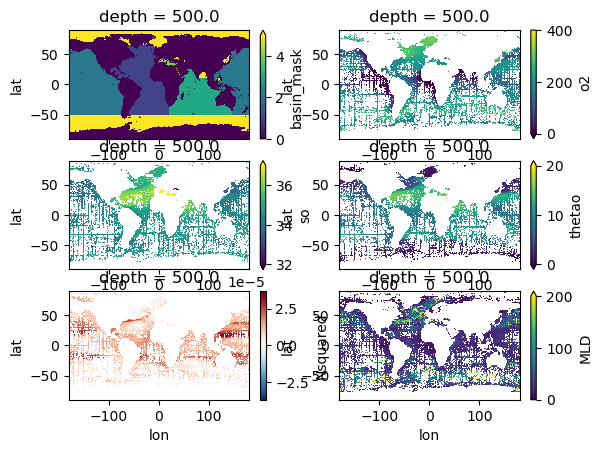

In [7]:
# take a look at the data
fig,ax=plt.subplots(3,2)
mask.plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
o2.mean('time').plot(ax=ax[0,1],vmin=0,vmax=400,label='O2')
so.mean('time').plot(ax=ax[1,0],vmin=32,vmax=37,label='S')
to.mean('time').plot(ax=ax[1,1],vmin=0,vmax=20,label='T')
dr.mean('time').plot(ax=ax[2,0],label='N2')
mld.mean('time').plot(ax=ax[2,1],vmin=0,vmax=200,label='MLD')

In [8]:
# select Atlantic basin
# Atlantic is mask = 1
ma = dsm.basin_mask.sel(depth=zlev).to_numpy()

### Prepare monthly climatology data so we can calculate anomalies

In [9]:
# monthly climatology
#dc0=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_all_o00_01.nc',decode_times=False)
#dc1=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_s00_01.nc',decode_times=False)
#dc2=xr.open_dataset('/glade/work/ito/dataset/ocean/woa/woa18_decav_t00_01.nc',decode_times=False)
dc0=xr.open_dataset(dir+'o2_'+model+'_196501-201412.nc')
dc1=xr.open_dataset(dir+'so_'+model+'_196501-201412.nc')
dc2=xr.open_dataset(dir+'thetao_'+model+'_196501-201412.nc')
dc3=xr.open_dataset(dira+'Nsquared_MLD_'+model+'_196501-201412.nc')

In [10]:
# extract 500m climatology
o2c=dc0.o2.sel(depth=zlev).groupby('time.month').mean('time')*1e3
soc=dc1.so.sel(depth=zlev).groupby('time.month').mean('time')
toc=dc2.thetao.sel(depth=zlev).groupby('time.month').mean('time')
drdzc=dc3.Nsquared.sel(depth=zlev).groupby('time.month').mean('time')
mldc=dc3.MLD.sel(depth=zlev).groupby('time.month').mean('time')

In [11]:
# subtract climatology from the discrete data to define anomalies
doa=o2.groupby('time.month')-o2c
dsa=so.groupby('time.month')-soc
dta=to.groupby('time.month')-toc
dra=dr.groupby('time.month')-drdzc
dha=mld.groupby('time.month')-mldc
#
# make numpy array
doa = doa.to_numpy()
dsa = dsa.to_numpy()
dta = dta.to_numpy()
dra = dra.to_numpy()
dha = dha.to_numpy()
#
# prepare lat lon data
xx1 = np.tile(xx,[600,1,1])
yy1 = np.tile(yy,[600,1,1])
tt0 = np.tile(np.arange(0,600,1),[180,360,1])
tt1 = np.transpose(tt0,(2,0,1))

In [12]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),doa,np.nan)
dsa=np.where((ma==1)&(yy>0),dsa,np.nan)
dta=np.where((ma==1)&(yy>0),dta,np.nan)
dra=np.where((ma==1)&(yy>0),dra,np.nan)
dha=np.where((ma==1)&(yy>0),dha,np.nan)

### Now we have the anormaly data for the North Atlantic. Remove NaNs and organize them into 1d array

In [13]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dra.flatten()
dha0 = dha.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()
tt0  = tt1.flatten()

In [14]:
# remove nan
dd = doa0 + dsa0 + dta0 + dra0 + dha0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
dha1=dha0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
tt1=tt0[np.isnan(dd)==False]
Nsample = np.size(doa1)
print(Nsample)

20329


In [15]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, dha1, xx1, yy1, tt1])
y = doa1
#
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
#
N=np.size(y)
# normalize x and y
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

## ML

### First split the data into training and test set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1,test_size=0.15)

In [17]:
a=y_train.size
b=y_test.size
a/(a+b)

0.8499680259727483

### MLR estimator (MLregr)

In [18]:
##
## Multiple Linear Regression
##
from sklearn.linear_model import LinearRegression

In [19]:
# fit model
MLregr = LinearRegression().fit(X_train, y_train)
#MLregr.coef_
#MLregr.intercept_
out=MLregr.predict(X_test)

0.44852840904460334
correlation =  0.6702061111219185
RMSE =  6.097940281164575


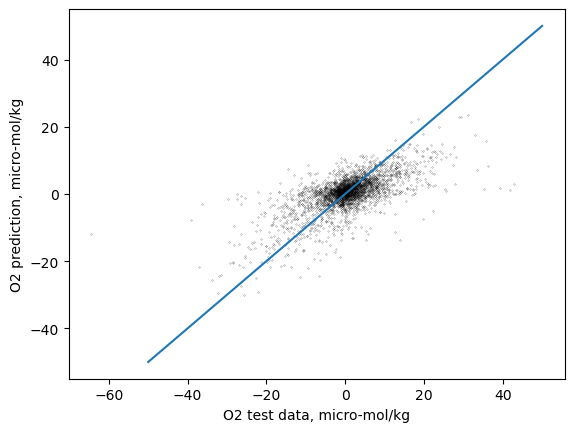

In [20]:
# test model output
score=MLregr.score(X_test, y_test)
print(score)
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_MLR=temp[0,1]
print('correlation = ',Rval_MLR)
RMSE_MLR=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_MLR)

### Support Vector Machine estimator (SVregr)

In [21]:
##
## Support Vector Regression
##
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV

In [22]:
clf = svm.SVR()
parameters = {'C':[1, 5, 10],'epsilon':[.1,.2,.5]}
SVregr = GridSearchCV(clf, parameters)
SVregr.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'epsilon': [0.1, 0.2, 0.5]})

In [23]:
SVregr.cv_results_

{'mean_fit_time': array([11.14640589,  8.52740688,  4.00286264, 14.11640043, 10.92696409,
         4.78668914, 17.72854061, 13.46166201,  5.64995799]),
 'std_fit_time': array([0.05377046, 0.06162102, 0.03261958, 0.13057218, 0.13092843,
        0.04303354, 0.18606781, 0.07055529, 0.09105678]),
 'mean_score_time': array([3.63812551, 2.81406317, 1.33535089, 3.58274932, 2.77224593,
        1.27331328, 3.56573138, 2.74339871, 1.24645467]),
 'std_score_time': array([0.01098966, 0.01948465, 0.00646219, 0.00985048, 0.01981698,
        0.01023925, 0.01220983, 0.01614202, 0.00899435]),
 'param_C': masked_array(data=[1, 1, 1, 5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_epsilon': masked_array(data=[0.1, 0.2, 0.5, 0.1, 0.2, 0.5, 0.1, 0.2, 0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill

In [24]:
# use the best fit parameter
out=SVregr.predict(X_test)

correlation =  0.8542165529968531
RMSE =  4.279124118061129


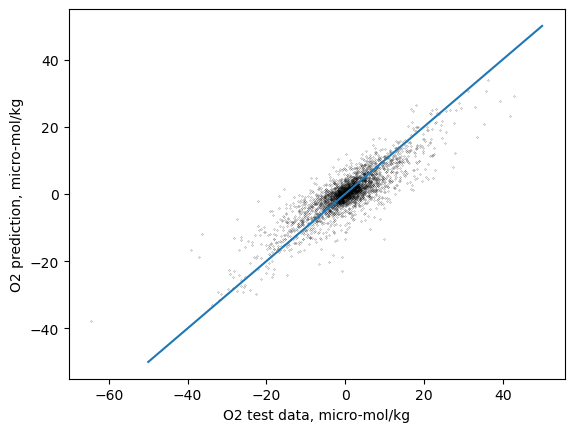

In [25]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_SV=temp[0,1]
print('correlation = ',Rval_SV)
RMSE_SV=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_SV)

### shallow Neural Network estimator (SNNregr)

In [26]:
## NN
from sklearn.neural_network import MLPRegressor

In [27]:
# shallow NN
clf = MLPRegressor(max_iter=1000)
parameters = {'hidden_layer_sizes':[[10,10],[20,20],[40,40]],'alpha':[.0001,.001,.01]}
sNNregr = GridSearchCV(clf, parameters)

In [28]:
sNNregr.fit(X_test,y_test)

GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [[10, 10], [20, 20], [40, 40]]})

In [29]:
out = sNNregr.predict(X_test)
sNNregr.cv_results_

{'mean_fit_time': array([2.39143944, 3.03199649, 2.79636078, 2.59223819, 2.6578166 ,
        3.28017673, 2.54889278, 2.96801491, 2.65623512]),
 'std_fit_time': array([0.21149467, 0.66369834, 0.29336252, 0.34777058, 0.49865143,
        0.72075411, 0.42392242, 0.32816546, 0.33112998]),
 'mean_score_time': array([0.00055952, 0.00062222, 0.00072389, 0.00054908, 0.00060287,
        0.000735  , 0.00054941, 0.00060267, 0.00072174]),
 'std_score_time': array([8.76317209e-06, 2.41207972e-05, 3.37983039e-06, 3.87384339e-06,
        2.73340428e-06, 2.19061917e-05, 2.65320353e-06, 2.37175562e-06,
        6.35357556e-06]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01,
                    0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([10, 10]), list([20, 20]), list([40, 40]),
           

correlation =  0.903120302074252
RMSE =  3.5409362792957824


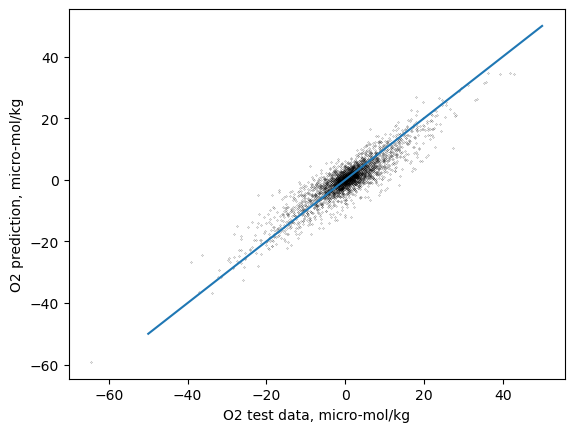

In [30]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_sNN=temp[0,1]
print('correlation = ',Rval_sNN)
RMSE_sNN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_sNN)

### deep Neural Network estimator (NNregr)

In [31]:
# deep NN 30-30-30-5
dNNregr = MLPRegressor(max_iter=1000).fit(X_train, y_train)

In [32]:
clf = MLPRegressor(max_iter=1000)
parameters = {'hidden_layer_sizes':[[10,10,10,10],[20,20,20,20],[40,40,40,40]],'alpha':[.0001,.001,.01]}
dNNregr = GridSearchCV(clf, parameters)

In [33]:
dNNregr.fit(X_test,y_test)

GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [[10, 10, 10, 10],
                                                [20, 20, 20, 20],
                                                [40, 40, 40, 40]]})

In [34]:
out = dNNregr.predict(X_test)
dNNregr.cv_results_

{'mean_fit_time': array([3.24410086, 2.99921718, 3.45721264, 3.41327853, 2.99628181,
        3.96811213, 3.2337657 , 2.72685165, 3.32707076]),
 'std_fit_time': array([0.62029938, 0.61188603, 0.41706118, 1.30228959, 0.51831021,
        0.54317213, 0.43866372, 0.58005822, 0.75069909]),
 'mean_score_time': array([0.00064206, 0.00075083, 0.00101986, 0.00065289, 0.00074825,
        0.00101609, 0.00065384, 0.00077267, 0.00100832]),
 'std_score_time': array([2.01623757e-05, 7.63892532e-06, 4.46447941e-06, 2.40160302e-05,
        9.08822102e-06, 7.42611683e-06, 3.57953877e-05, 2.16278113e-05,
        9.18750256e-06]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01,
                    0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([10, 10, 10, 10]), list([20, 20, 20, 20]),
           

correlation =  0.9190949947267147
RMSE =  3.3831284465664924


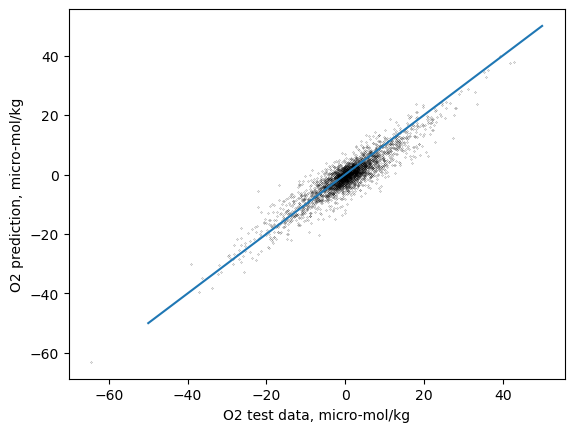

In [35]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([-50,50],[-50,50])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)